In [1]:
import os
import torch
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import average_precision_score
import torchvision
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches

# Setting up hyperparameters and configuration
model_name = "retinanet"  # Model selection: "fasterrcnn" or "retinanet"
num_epochs = 200  # Number of epochs for training
learning_rate = 0.005  # Learning rate for optimizer
batch_size = 4  # Batch size for DataLoader
num_classes = 3  # Number of classes (e.g., meningioma, glioma, pituitary tumor)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Use GPU if available, else fallback to CPU
optimizer_choice = 'sgd'  # Optimizer choice: 'sgd' or 'adam'
score_threshold = 0.5  # Score threshold for filtering predictions

# Path to save the best performing model during training
checkpoint_path = "retinanet_All_Trasnformation.pth"

# Function to print the hyperparameters in an organized format
def print_hyperparameters():
    print("Hyperparameters:")
    print("="*40)
    print(f"Model Name: {model_name}")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Batch Size: {batch_size}")
    print(f"Number of Classes: {num_classes}")
    print(f"Optimizer Choice: {optimizer_choice}")
    print("="*40)

# Display the hyperparameters
print_hyperparameters()

# Data augmentation and preprocessing for the training set
train_transform = A.Compose([
    A.Resize(256, 256),  # Resize images to 256x256
    A.RandomBrightnessContrast(p=0.2),  # Apply random brightness and contrast changes
    A.HorizontalFlip(p=0.5),  # Randomly flip images horizontally
    A.GaussianBlur(blur_limit=3, p=0.2),  # Apply Gaussian blur with a small chance
    A.Rotate(limit=15, p=0.5),  # Random rotation within a 15-degree range
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),  # Shift, scale, and rotate images
    ToTensorV2()  # Convert images to PyTorch tensors
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Minimal preprocessing for validation and test sets
test_transform = A.Compose([
    A.Resize(256, 256),  # Resize images to 256x256
    ToTensorV2()  # Convert images to PyTorch tensors
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))




INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


Hyperparameters:
Model Name: retinanet
Number of Epochs: 200
Learning Rate: 0.005
Batch Size: 4
Number of Classes: 3
Optimizer Choice: sgd


/user/HS402/rk01219/.local/lib/python3.10/site-packages/pydantic/main.py:175: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


# Model Setup


In [2]:
# Function to setup the model (either Faster R-CNN or RetinaNet)
def setup_model(model_name, num_classes, device):
    if model_name == "fasterrcnn":
        print("Setting up Faster R-CNN model...")
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)  # Load a pre-trained Faster R-CNN model
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)  # Replace the classifier head
        backbone_name = "ResNet50"
        
    elif model_name == "retinanet":
        print("Setting up RetinaNet model...")
        model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)  # Load a pre-trained RetinaNet model
        in_features = model.head.classification_head.conv[0].out_channels
        num_anchors = model.head.classification_head.num_anchors
        model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(in_features, num_anchors, num_classes)  # Replace the classification head
        backbone_name = "ResNet50"

    else:
        raise ValueError(f"Unknown model name: {model_name}")  # Handle unknown model names
    
    model.to(device)  # Move model to the appropriate device (GPU/CPU)
    return model, backbone_name

# Initialize the model and backbone based on the chosen configuration
model, backbone_name = setup_model(model_name, num_classes, device)

# Function to print a summary of the model architecture and other details
def print_model_summary(model, model_name, backbone_name, input_size, num_classes, device):
    total_params = sum(p.numel() for p in model.parameters())  # Calculate total parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # Calculate trainable parameters
    print(f"\nModel Summary for {model_name}:")
    print("="*40)
    print(f"Model Name: {model_name}")
    print(f"Backbone Architecture: {backbone_name}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Input Size: {input_size}")
    print(f"Output Classes: {num_classes}")
    print(f"Pre-trained: {'Yes' if model_name in ['fasterrcnn', 'retinanet', 'cascade_rcnn'] else 'No'}")
    print(f"Device: {device}")
    print("="*40)

# Print the model summary
print_model_summary(model, model_name, backbone_name, (1, 256, 256), num_classes, device)

Setting up RetinaNet model...


/user/HS402/rk01219/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/user/HS402/rk01219/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /user/HS402/rk01219/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|█████████████████████████████████████████| 130M/130M [00:01<00:00, 115MB/s]



Model Summary for retinanet:
Model Name: retinanet
Backbone Architecture: ResNet50
Total Parameters: 32,189,439
Trainable Parameters: 31,967,039
Input Size: (1, 256, 256)
Output Classes: 3
Pre-trained: Yes
Device: cuda


# Dataloading and  visualization

Number of images in the training set: 2113
Number of images in the validation set: 264
Number of images in the test set: 265


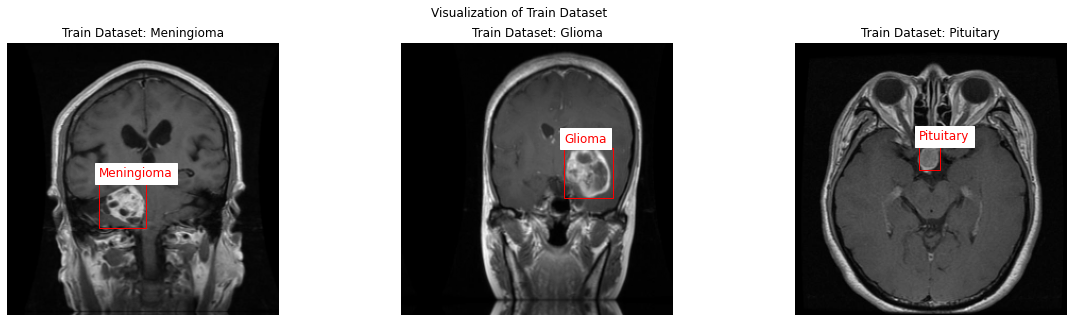

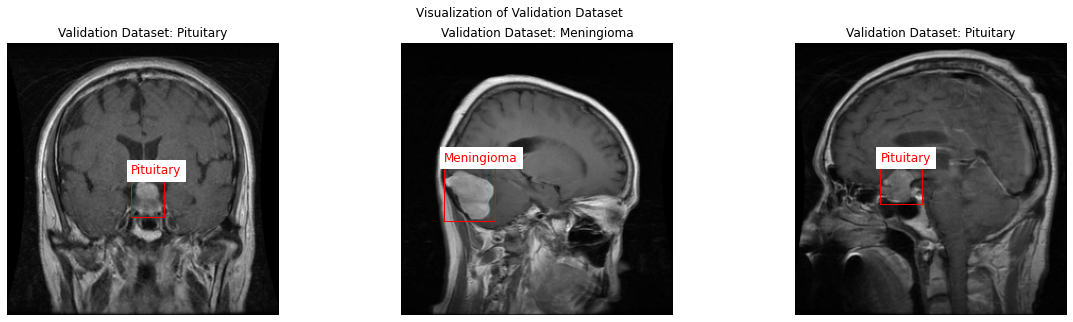

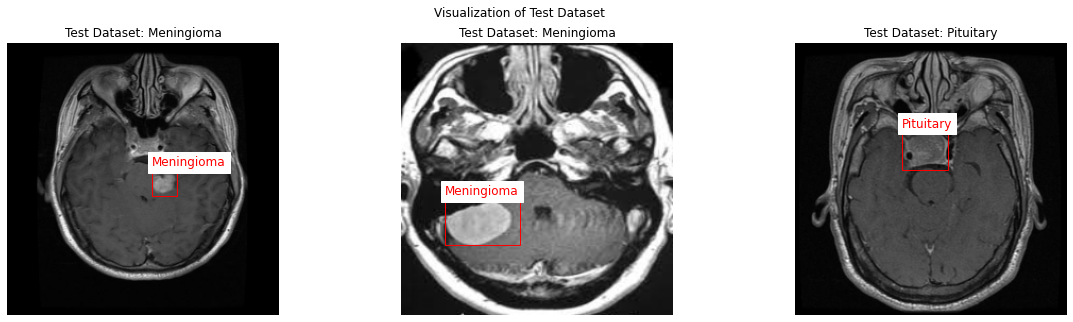

In [3]:
import os
import torch
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Custom dataset class for loading images and annotations
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, annotation_paths, transforms=None):
        self.image_paths = image_paths  # List of image file paths
        self.annotation_paths = annotation_paths  # List of annotation file paths
        self.transforms = transforms  # Data augmentation/transformation pipeline

    def __len__(self):
        return len(self.image_paths)  # Return the number of images

    def __getitem__(self, idx):
        # Load image from file and convert to grayscale
        img_path = self.image_paths[idx]
        img = np.array(Image.open(img_path).convert("L"))

        # Normalize image to [0, 1] range
        img = img.astype(np.float32) / 255.0

        # Load corresponding annotation (bounding boxes and labels)
        label_path = self.annotation_paths[idx]
        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            # Parse each line in the annotation file
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0]) - 1  # Convert class IDs to 0-indexed
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Calculate the bounding box coordinates
                x_min = max(0, (x_center - width / 2))
                y_min = max(0, (y_center - height / 2))
                x_max = min(1, (x_center + width / 2))
                y_max = min(1, (y_center + height / 2))

                # Scale box coordinates to match image dimensions
                img_width, img_height = img.shape[1], img.shape[0]
                x_min *= img_width
                y_min *= img_height
                x_max *= img_width
                y_max *= img_height

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)

        # Convert boxes and labels to tensors
        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        # Apply data augmentations/transforms if provided
        if self.transforms:
            transformed = self.transforms(image=img.copy(), bboxes=boxes, labels=labels)
            img = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.as_tensor(transformed['labels'], dtype=torch.int64)
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for grayscale (1, H, W)

        return img, target

    # Utility function to print a summary of the dataset
    def print_summary(self):
        total_images = len(self.image_paths)
        print(f"Total number of images: {total_images}")

# Custom collate function to handle batches in DataLoader
def custom_collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

# Function to visualize random samples from the dataset
def visualize_random_samples(dataset, dataset_type="Dataset", class_names=None, num_images=3):
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, idx in enumerate(indices):
        img, target = dataset[idx]

        # Convert tensor image to numpy array and handle normalization
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)
        img = (255 * img).astype(np.uint8)  # Convert [0, 1] float to [0, 255] uint8

        ax = axes[i]
        ax.imshow(img.squeeze(), cmap='gray')  # Display as grayscale using 'gray' colormap

        if len(target['labels']) > 0:
            for box, label in zip(target['boxes'], target['labels']):
                x_min, y_min, x_max, y_max = box
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red')
                ax.add_patch(rect)
                
                # Convert label tensor to int before accessing class_names
                label = int(label)
                
                ax.text(x_min, y_min - 5, class_names[label], color='red', fontsize=12, backgroundcolor='white')
            ax.set_title(f"{dataset_type}: {class_names[int(target['labels'][0])]}")  # Convert to int here as well
        else:
            ax.set_title(f"{dataset_type}: No Tumor")

        ax.axis('off')

    plt.suptitle(f"Visualization of {dataset_type}")
    plt.show()

# Define the paths to the images and annotations directories
images_dir = '/user/HS402/rk01219/Downloads/Segmentation/archive/Brain Tumor Segmentation Dataset/image'
annotations_dir = '/user/HS402/rk01219/Downloads/Segmentation/annotations/image'

# Collect all image and annotation paths, excluding class 0 (No Tumor)
all_image_paths = []
all_annotation_paths = []
for class_dir in os.listdir(images_dir):
    if class_dir == "0":  # Skip the "No Tumor" class
        continue

    img_dir = os.path.join(images_dir, class_dir)
    anno_dir = os.path.join(annotations_dir, class_dir)
    if not os.path.isdir(img_dir):
        continue

    images = sorted([fname for fname in os.listdir(img_dir) if fname.endswith(('.png', '.jpg'))])
    for img_name in images:
        all_image_paths.append(os.path.join(img_dir, img_name))
        all_annotation_paths.append(os.path.join(anno_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt')))

# Split into train, validation, and test sets (80%, 10%, 10%)
train_img_paths, val_test_img_paths, train_ann_paths, val_test_ann_paths = train_test_split(
    all_image_paths, all_annotation_paths, test_size=0.2, random_state=42)

val_img_paths, test_img_paths, val_ann_paths, test_ann_paths = train_test_split(
    val_test_img_paths, val_test_ann_paths, test_size=0.5, random_state=42)

# Initialize datasets with the defined transforms
train_dataset = CustomDataset(train_img_paths, train_ann_paths, transforms=train_transform)
val_dataset = CustomDataset(val_img_paths, val_ann_paths, transforms=test_transform)
test_dataset = CustomDataset(test_img_paths, test_ann_paths, transforms=test_transform)

# Initialize DataLoaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

# Print number of images in each dataset
print(f"Number of images in the training set: {len(train_dataset)}")
print(f"Number of images in the validation set: {len(val_dataset)}")
print(f"Number of images in the test set: {len(test_dataset)}")

# Visualize some samples from the datasets
class_names = {0: 'Glioma', 1: 'Meningioma', 2: 'Pituitary'}  # Class names mapped to labels
visualize_random_samples(train_dataset, dataset_type="Train Dataset", class_names=class_names)
visualize_random_samples(val_dataset, dataset_type="Validation Dataset", class_names=class_names)
visualize_random_samples(test_dataset, dataset_type="Test Dataset", class_names=class_names)


In [4]:
def count_tumor_types(dataset, class_names):
    # Initialize a dictionary to count occurrences of each tumor type
    counts = {class_name: 0 for class_name in class_names.values()}
    
    # Iterate over each sample in the dataset
    for img, target in dataset:
        labels = target['labels'].numpy()  # Extract labels as a numpy array
        
        # Count each label occurrence in the dataset
        for label in labels:
            class_name = class_names[label]  # Map label to class name
            counts[class_name] += 1  # Increment the count for the corresponding tumor type
    
    return counts

# Count the occurrences of each tumor type in the training, validation, and test sets
train_counts = count_tumor_types(train_dataset, class_names)
val_counts = count_tumor_types(val_dataset, class_names)
test_counts = count_tumor_types(test_dataset, class_names)

# Print the number of images for each tumor type in the training set
print("Number of images for each tumor type in the training set:")
for tumor_type, count in train_counts.items():
    print(f"{tumor_type}: {count}")

# Print the number of images for each tumor type in the validation set
print("\nNumber of images for each tumor type in the validation set:")
for tumor_type, count in val_counts.items():
    print(f"{tumor_type}: {count}")

# Print the number of images for each tumor type in the test set
print("\nNumber of images for each tumor type in the test set:")
for tumor_type, count in test_counts.items():
    print(f"{tumor_type}: {count}")


Number of images for each tumor type in the training set:
Glioma: 510
Meningioma: 799
Pituitary: 804

Number of images for each tumor type in the validation set:
Glioma: 74
Meningioma: 93
Pituitary: 97

Number of images for each tumor type in the test set:
Glioma: 65
Meningioma: 107
Pituitary: 93


In [5]:
# Optimizer selection
params = [p for p in model.parameters() if p.requires_grad]
if optimizer_choice == 'sgd':
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
elif optimizer_choice == 'adam':
    optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0005)
else:
    raise ValueError(f"Unknown optimizer choice: {optimizer_choice}")

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Evaluation and Training

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Function to calculate Intersection over Union (IoU) between two bounding boxes
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])  # Determine the (x, y)-coordinates of the intersection rectangle
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxB[3], boxB[3])
    
    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # Compute the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # Compute the IoU by dividing the intersection area by the union area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

# Evaluation function to compute metrics on the validation or test dataset
def evaluate(model, dataloader, device, class_names, score_threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []  # Store all predicted bounding boxes
    all_targets = []  # Store all ground truth bounding boxes

    with torch.no_grad():  # Disable gradient computation
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)  # Move images to the device
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to the device

            # Handle cases where there are no bounding boxes
            for target in targets:
                if len(target['boxes']) == 0:
                    target['boxes'] = torch.zeros((0, 4), dtype=torch.float32, device=device)
                    target['labels'] = torch.zeros((0,), dtype=torch.int64, device=device)

            predictions = model(images)  # Get predictions from the model

            # Extract and store predictions and corresponding targets
            for i in range(len(targets)):
                pred_boxes = predictions[i]['boxes'].cpu().numpy()
                pred_scores = predictions[i]['scores'].cpu().numpy()
                true_boxes = targets[i]['boxes'].cpu().numpy()
                
                # Filter predictions based on score threshold
                pred_boxes = pred_boxes[pred_scores >= score_threshold]

                all_predictions.append(pred_boxes)
                all_targets.append(true_boxes)

    # Initialize lists to store metrics for each image
    average_precisions = []
    precisions = []
    recalls = []
    IOUs = []
    F1_scores = []

    # Compute metrics for each image
    for i in range(len(all_predictions)):
        true_boxes = all_targets[i]
        pred_boxes = all_predictions[i]

        # Handle cases with no true or predicted boxes
        if len(true_boxes) == 0 and len(pred_boxes) == 0:
            precision_i, recall_i, f1_i = 0, 0, 0
            IOU_i = 0
            average_precisions.append(0.0)
        elif len(true_boxes) == 0 or len(pred_boxes) == 0:
            precision_i, recall_i, f1_i = 0, 0, 0
            IOU_i = 0
            average_precisions.append(0.0)
        else:
            # Calculate IoU between all predicted and true boxes
            ious = np.zeros((len(pred_boxes), len(true_boxes)))
            for pred_idx, pred_box in enumerate(pred_boxes):
                for true_idx, true_box in enumerate(true_boxes):
                    ious[pred_idx, true_idx] = calculate_iou(pred_box, true_box)

            # Match predicted and true boxes based on IoU threshold
            matched_pred_indices = set()
            matched_true_indices = set()

            for pred_idx in range(len(pred_boxes)):
                best_iou = 0
                best_true_idx = -1
                for true_idx in range(len(true_boxes)):
                    if true_idx in matched_true_indices:
                        continue
                    iou = ious[pred_idx, true_idx]
                    if iou > best_iou:
                        best_iou = iou
                        best_true_idx = true_idx

                if best_iou > 0.5:
                    matched_pred_indices.add(pred_idx)
                    matched_true_indices.add(best_true_idx)

            # Calculate precision, recall, F1 score, and IoU for the current image
            true_positive = len(matched_pred_indices)
            false_positive = len(pred_boxes) - true_positive
            false_negative = len(true_boxes) - len(matched_true_indices)

            if true_positive + false_positive == 0 or true_positive + false_negative == 0:
                print(f"Warning: True Positives: {true_positive}, False Positives: {false_positive}, False Negatives: {false_negative}")

            precision_i = true_positive / (true_positive + false_positive + 1e-8)
            recall_i = true_positive / (true_positive + false_negative + 1e-8)

            assert 0 <= precision_i <= 1, f"Precision out of bounds: {precision_i}"
            assert 0 <= recall_i <= 1, f"Recall out of bounds: {recall_i}"

            if (precision_i + recall_i) == 0:
                f1_i = 0.0
            else:
                f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i + 1e-8)

            assert 0 <= f1_i <= 1, f"F1 Score out of bounds: {f1_i}"

            IOU_i = ious.max(axis=1).mean()

            precisions.append(precision_i)
            recalls.append(recall_i)
            IOUs.append(IOU_i)
            F1_scores.append(f1_i)

            # Calculate average precision using sklearn
            true_labels = np.ones(len(pred_boxes))
            pred_scores = (ious.max(axis=1) > 0.5).astype(float)
            avg_precision = average_precision_score(true_labels, pred_scores)
            average_precisions.append(avg_precision)

            if avg_precision > 1:
                print(f"Warning: Average Precision is more than 1: {avg_precision}")

    # Compute mean metrics across all images
    mean_average_precision = np.mean(average_precisions) if len(average_precisions) > 0 else 0.0
    mean_precision = np.mean(precisions) if len(precisions) > 0 else 0.0
    mean_recall = np.mean(recalls) if len(recalls) > 0 else 0.0
    mean_IOU = np.mean(IOUs) if len(IOUs) > 0 else 0.0
    mean_F1_score = np.mean(F1_scores) if len(F1_scores) > 0 else 0.0

    return mean_average_precision, mean_IOU, mean_F1_score, mean_precision, mean_recall

# Initialize lists to store evaluation metrics over epochs
val_mAPs = []
val_IOUs = []
val_F1s = []
val_precisions = []
val_recalls = []

best_val_loss = float('inf')
best_model_state = None

# Training loop over all epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_batches = 0

    # Iterate over batches of training data
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)  # Move images to the device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to the device

        optimizer.zero_grad()  # Clear the gradients from the previous step
        loss_dict = model(images, targets)  # Forward pass through the model
        losses = sum(loss for loss in loss_dict.values())  # Sum up the losses

        # Handle unusual or NaN losses
        if torch.isnan(losses) or losses.item() > 1e6:
            print(f"Warning: Unusual loss detected at Epoch {epoch+1}, Batch {batch_idx+1}: {losses.item()}")
            continue

        losses.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model parameters

        total_loss += losses.item()  # Accumulate total loss
        total_batches += 1  # Count batches

    # Compute average training loss for the epoch
    average_train_loss = total_loss / total_batches

    # Print analysis for the first batch of the first epoch
    if epoch == 0 and batch_idx == 0:
        print(f"Single Batch Analysis at Epoch 1, Batch 1 - Loss: {losses.item()}")

    # Evaluate the model on the validation set
    val_mAP, val_IOU, val_F1, val_precision, val_recall = evaluate(model, val_loader, device, class_names)

    # # Check for unusual metric values
    # if val_F1 > 1 or val_precision > 1 or val_recall > 1:
    #     print(f"Warning: Unusual metric values at Epoch {epoch+1}: Val F1: {val_F1}, Precision: {val_precision}, Recall: {val_recall}")

    # Store evaluation metrics for the current epoch
    val_mAPs.append(val_mAP)
    val_IOUs.append(val_IOU)
    val_F1s.append(val_F1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    # Print the metrics for the current epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {average_train_loss:.4f}, "
          f"Val mAP: {val_mAP:.4f}, Val IoU: {val_IOU:.4f}, Val F1 Score: {val_F1:.4f}, "
          f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

    # Save the model state with the best validation loss
    if average_train_loss < best_val_loss:
        best_val_loss = average_train_loss
        best_model_state = model.state_dict()

    lr_scheduler.step()  # Step the learning rate scheduler

# Save the best model state to the checkpoint
print(f"Best validation loss: {best_val_loss:.4f}. Saving model ...")
torch.save(best_model_state, checkpoint_path)

def plot_metrics(val_mAPs, val_IOUs, val_F1s, val_precisions, val_recalls):
    epochs = range(1, len(val_mAPs) + 1)

    plt.figure(figsize=(14, 10))

    plt.plot(epochs, val_mAPs, 'g-o', label='Validation mAP')
    plt.plot(epochs, val_IOUs, 'm-o', label='Validation IoU')
    plt.plot(epochs, val_F1s, 'c-o', label='Validation F1 Score')
    # plt.plot(epochs, val_precisions, 'b-o', label='Validation Precision')
    # plt.plot(epochs, val_recalls, 'r-o', label='Validation Recall')

    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Validation Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(val_mAPs, val_IOUs, val_F1s, val_precisions, val_recalls)

Epoch [1/200], Train Loss: 1.0869, Val mAP: 0.1780, Val IoU: 0.8677, Val F1 Score: 0.8972, Val Precision: 0.8475, Val Recall: 1.0000
Epoch [2/200], Train Loss: 0.5930, Val mAP: 0.6136, Val IoU: 0.8311, Val F1 Score: 0.9270, Val Precision: 0.8961, Val Recall: 0.9938
Epoch [3/200], Train Loss: 0.5321, Val mAP: 0.6174, Val IoU: 0.8808, Val F1 Score: 0.8793, Val Precision: 0.8241, Val Recall: 0.9939
Epoch [4/200], Train Loss: 0.4784, Val mAP: 0.6742, Val IoU: 0.8443, Val F1 Score: 0.9663, Val Precision: 0.9551, Val Recall: 0.9888
Epoch [5/200], Train Loss: 0.4354, Val mAP: 0.7841, Val IoU: 0.8367, Val F1 Score: 0.9855, Val Precision: 0.9831, Val Recall: 0.9903
Epoch [6/200], Train Loss: 0.3408, Val mAP: 0.9583, Val IoU: 0.8465, Val F1 Score: 0.9631, Val Precision: 0.9513, Val Recall: 0.9881
Epoch [7/200], Train Loss: 0.3206, Val mAP: 0.9583, Val IoU: 0.8574, Val F1 Score: 0.9625, Val Precision: 0.9519, Val Recall: 0.9842
Epoch [8/200], Train Loss: 0.3157, Val mAP: 0.9583, Val IoU: 0.8576, 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_data(data, window_size=5):
    # Use np.pad to handle the edges
    padded_data = np.pad(data, (window_size//2, window_size-1-window_size//2), mode='edge')
    smoothed_data = np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data

def plot_metrics(val_mAPs, val_IOUs, val_F1s, window_size=5):
    epochs = range(1, len(val_mAPs) + 1)

    # Smooth the metrics
    smoothed_mAPs = smooth_data(val_mAPs, window_size)
    smoothed_IOUs = smooth_data(val_IOUs, window_size)
    smoothed_F1s = smooth_data(val_F1s, window_size)

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plotting smooth mAP, IoU, and F1 Score curves
    ax1.plot(epochs, smoothed_mAPs, 'g-', label='Val mAP')
    ax1.plot(epochs, smoothed_IOUs, 'm-', label='Val IoU')
    ax1.plot(epochs, smoothed_F1s, 'c-', label='Val F1 Score')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Metrics')
    ax1.set_ylim(0, 1)  # Ensure the y-axis starts from 0 and extends to 1
    ax1.legend(loc='lower right')
    ax1.set_title('Validation Metrics (mAP, IoU, F1 Score)')
    ax1.grid(True)

    # Adjust layout to prevent overlap and display the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics(val_mAPs, val_IOUs, val_F1s, window_size=5)


# Test Set

In [ ]:

# Evaluate on test set
model.load_state_dict(torch.load(checkpoint_path))  # Load the best model for testing
test_mAP, test_IOU, test_F1, test_precision, test_recall = evaluate(model, test_loader, device, class_names)
print(f"Test mAP: {test_mAP:.4f}, Test IoU: {test_IOU:.4f}, Test F1 Score: {test_F1:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")



In [ ]:
# Function to visualize random test images
def visualize_random_test_images(model, dataset, device, class_names=None, num_images=5, score_threshold=0.1):
    model.eval()
    num_classes = len(class_names)
    class_indices = {i: [] for i in range(num_classes)}

    # Collect indices of images containing only one class
    for idx in range(len(dataset)):
        _, target = dataset[idx]
        if len(set(target['labels'].tolist())) == 1:  # Ensure only one class label in the image
            label = target['labels'].tolist()[0]
            class_indices[label].append(idx)

    # Ensure at least one image per class
    selected_indices = []
    for indices in class_indices.values():
        if indices:
            selected_indices.append(random.choice(indices))

    # Fill the remaining slots with random samples from the dataset
    while len(selected_indices) < num_images:
        selected_indices.append(random.choice(range(len(dataset))))

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    with torch.no_grad():
        for i, idx in enumerate(selected_indices):
            img, target = dataset[idx]

            # Convert image to PyTorch tensor and move to the device
            if isinstance(img, torch.Tensor):
                img_tensor = img.unsqueeze(0).to(device)  # Add batch dimension
            else:
                img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension

            prediction = model(img_tensor)[0]

            # Apply confidence threshold
            high_conf_indices = prediction['scores'] >= score_threshold
            if high_conf_indices.sum() > 0:
                # Get the box with the highest score
                best_index = torch.argmax(prediction['scores'][high_conf_indices]).item()
                pred_boxes = prediction['boxes'][high_conf_indices][best_index].unsqueeze(0).cpu().numpy()
                pred_scores = prediction['scores'][high_conf_indices][best_index].unsqueeze(0).cpu().numpy()
                pred_labels = prediction['labels'][high_conf_indices][best_index].unsqueeze(0).cpu().numpy()
            else:
                pred_boxes = np.array([])
                pred_scores = np.array([])
                pred_labels = np.array([])

            # Convert image to numpy array for visualization
            img = img_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            img = (255 * img).astype(np.uint8).squeeze()  # Remove channel dimension if needed

            ax = axes[i]
            ax.imshow(img, cmap='gray')

            # Plot ground truth boxes
            for box, label in zip(target['boxes'], target['labels']):
                x_min, y_min, x_max, y_max = box.cpu().numpy()
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='green', facecolor='none')
                label_name = class_names.get(label.item(), "Unknown")  # Handle the case where label is not in class_names
                ax.add_patch(rect)
                ax.text(x_min, y_min - 10, label_name, color='green', fontsize=8, backgroundcolor='white')

            # Plot predicted boxes with confidence scores and class names
            for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
                label_name = class_names.get(label.item(), "Unknown")  # Handle the case where label is not in class_names
                ax.add_patch(rect)
                ax.text(x_min, y_min - 10, f'{label_name}: {score:.2f}', color='red', fontsize=8, backgroundcolor='white')

            ax.axis('off')
            ax.set_title(f"Test Image {idx}")

    plt.suptitle("Random Test Images with Ground Truth (Green) and Predictions (Red)")
    plt.show()

# Visualize random images from the test set
visualize_random_test_images(model, test_dataset, device, class_names=class_names, score_threshold=0.1)


In [ ]:
# Visualize random images from the test set
visualize_random_test_images(model, test_dataset, device, class_names=class_names, score_threshold=0.5)


# External Validation 

In [ ]:
# Define the paths to the external validation dataset
external_images_dir = '/user/HS402/rk01219/Downloads/Detection/archive/dataset_brain tumor_correct/Train/Images/'  # Directory containing external validation images
external_annotations_dir = '/user/HS402/rk01219/Downloads/Detection/archive/dataset_brain tumor_correct/Train/Labels/'  # Directory containing corresponding annotations

# Collect all image and annotation paths for the external validation set
external_image_paths = sorted([os.path.join(external_images_dir, fname) 
                               for fname in os.listdir(external_images_dir) 
                               if fname.endswith(('.png', '.jpg'))])  # Get all image file paths

external_annotation_paths = sorted([os.path.join(external_annotations_dir, fname.replace('.jpg', '.txt').replace('.png', '.txt')) 
                                    for fname in os.listdir(external_images_dir) 
                                    if fname.endswith(('.png', '.jpg'))])  # Get all corresponding annotation file paths

# Initialize the external validation dataset
external_dataset = CustomDataset(external_image_paths, external_annotation_paths, transforms=test_transform)  # Use the same test_transform defined earlier

# Initialize DataLoader for the external validation dataset
external_loader = torch.utils.data.DataLoader(external_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)  # No shuffling for validation

# Print the number of images in the external validation dataset
print(f"Number of images in the external validation set: {len(external_image_paths)}")

# Count the occurrences of each tumor type in the external validation set
ex_test_counts = count_tumor_types(external_dataset, class_names)

# Print the counts for each tumor type
print("\nNumber of images for each tumor type in the external validation set:")
for tumor_type, count in ex_test_counts.items():
    print(f"{tumor_type}: {count}")


In [ ]:
# Load the best model state from the checkpoint
model.load_state_dict(torch.load(checkpoint_path))  # Load the model weights that achieved the best performance during training

# Evaluate the model on the external validation dataset
external_mAP, external_IOU, external_F1, external_precision, external_recall = evaluate(
    model, external_loader, device, class_names
)  # Compute performance metrics on the external validation set

# Print the evaluation results for the external validation set
print(f"External Validation mAP: {external_mAP:.4f}, External Validation IoU: {external_IOU:.4f}, "
      f"External Validation F1 Score: {external_F1:.4f}, External Validation Precision: {external_precision:.4f}, "
      f"External Validation Recall: {external_recall:.4f}")  # Output the computed metrics to understand model performance on external data

# Visualize random images from the external validation dataset along with the model's predictions
visualize_random_test_images(model, external_dataset, device, class_names=class_names, score_threshold=0.1)  # Visualize predictions on random samples from the external validation set


In [ ]:
# Visualize random images from the external validation dataset along with the model's predictions
visualize_random_test_images(model, external_dataset, device, class_names=class_names, score_threshold=0.1)  # Visualize predictions on random samples from the external validation set
